# MNT Exchange Rate Analysis

This is an exploratory analysis of the USD to MNT exchange rate from 2008 to 2018. Since 2008 the Mongolian Tugrik has depreciated significantly. Questions to be explored:

- Is there a seasonality to the exchange rate? A seasonality will help predict trends and can be useful for those wishing to hedge inflation risks.
- Is there a correlation with money supply, foreign currency deposits, or other external factors? External factors are listed below.
- Is it possible to predict exchange rates using ARIMA, ARMA, or additive models?
- 


External factors to test:
- M1 and M2 money supplies
- Foreign currency on deposit
- Inflation rates
- Interest rates (policy rate)
- Balance of Payments

Order of testing:
- visualize time series perform ARIMA model and additive model testing
- Include external data and determine where correlations exist
- determine feature importance of external data
- assess viability to predict exchange rates

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import autocorrelation_plot
%matplotlib inline

plt.style.use('C:\\Users\\rober\\.matplotlib\\mpl_configdir\\stylelib\\mds.mplstyle')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import Excel file with MNT-USD exchange rates from 2008 to 2018. Also convert "Date" column to datetime. 

In [3]:
mnt = pd.read_excel("EXCHANGE_RATE.xlsx", converters= {'Date': pd.to_datetime})
mnt.head()

,Date,USD
0,2008-01-02,1169.97
1,2008-01-03,1169.97
2,2008-01-04,1169.97
3,2008-01-07,1169.81
4,2008-01-08,1170.11


In [4]:
mnt.dtypes

Date    datetime64[ns]
USD            float64
dtype: object

Text(0.5,1,'Time series of MNT-USD exchange rate')

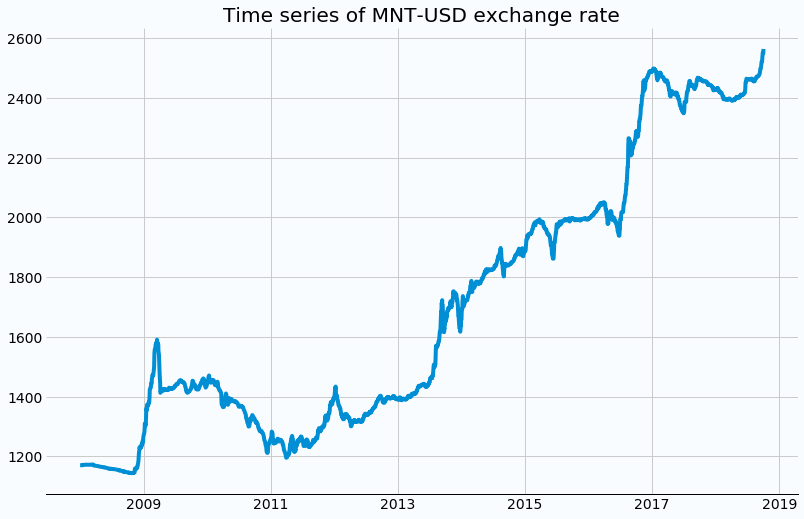

In [5]:
plt.plot(mnt['Date'], mnt['USD'])
plt.title('Time series of MNT-USD exchange rate')

Text(0.5,1,'Histogram of USD-MNT Exchange Rate')

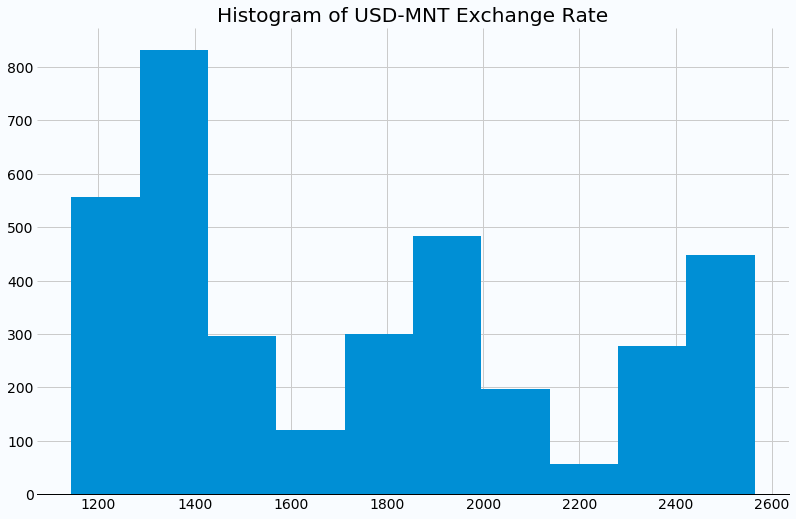

In [6]:
plt.hist(mnt['USD'])
plt.title('Histogram of USD-MNT Exchange Rate')

Text(0.5,1,'Autocorrelation plot')

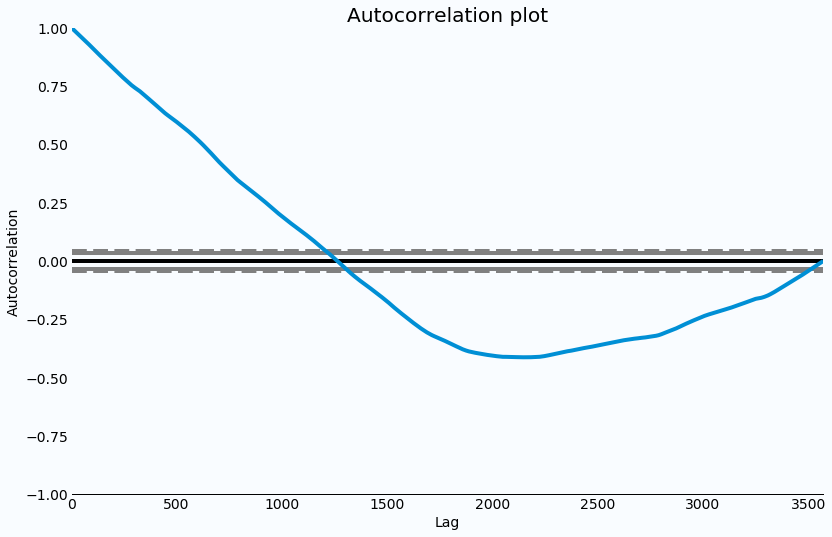

In [8]:
autocorrelation_plot(mnt['USD'])
plt.title('Autocorrelation plot')

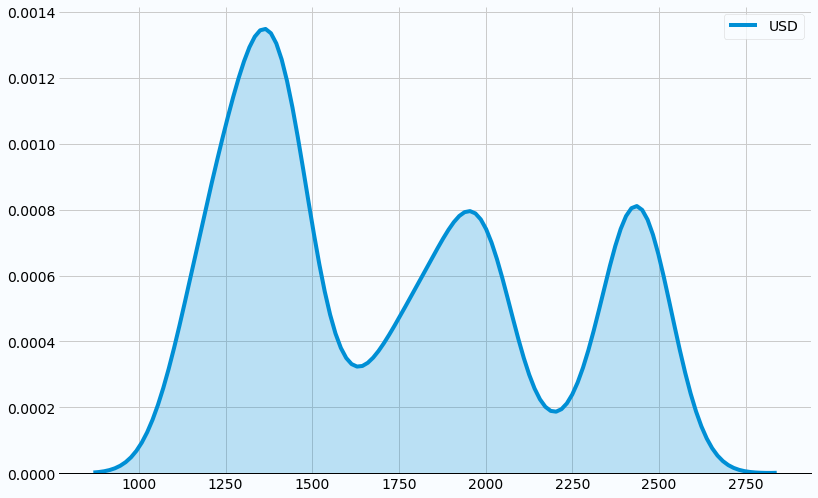

In [9]:
sns.kdeplot(mnt['USD'], shade=True);

### Create daily change in MNT
We want to visualize the frequencies of a gain or loss in the USD-MNT exchange rate. First we can calculate the change in rate over a period of 1 day. 

In [10]:
mnt.head()

,Date,USD
0,2008-01-02,1169.97
1,2008-01-03,1169.97
2,2008-01-04,1169.97
3,2008-01-07,1169.81
4,2008-01-08,1170.11


In [11]:
mnt['change'] = mnt['USD'] - mnt['USD'].shift(periods=1)

In [12]:
mnt = mnt.dropna()

Text(0.5,1,'Density plot of MNT-USD rate changes')

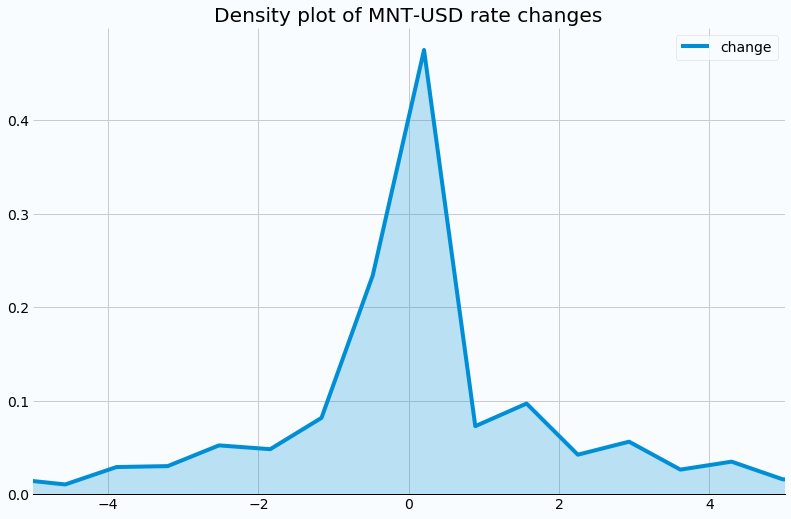

In [13]:
sns.kdeplot(mnt['change'], shade=True)
plt.xlim(-5,5)
plt.title('Density plot of MNT-USD rate changes')

## Determinations from visualizations
- We can see that the majority of the time the MNT-USD rate increases, meaning the tugrik is depreciating relative to the dollar. 
- There is a clear upwards trend. This tells us our time series is not stationary. 
- ARIMA modeling requires a stationary time series. This can be created through a process called differencing.

Things to try:
- Take log of time series
- make rolling mean

## Difference time series to make stationary

In [33]:
mnt['log-USD'] = np.log(mnt['USD'])
mnt['rolling-avg'] = mnt['log-USD'].rolling(window=30,center=False).mean()

Text(0.5,1,'Moving average window')

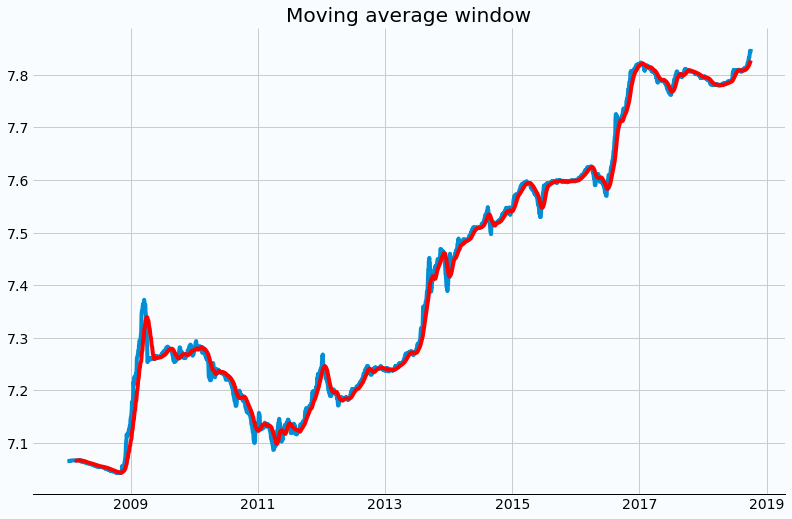

In [34]:
plt.plot(mnt['Date'],mnt['log-USD'])
plt.plot(mnt['Date'],mnt['rolling-avg'], color='red')
plt.title('Moving average window')

In [35]:
mnt.head()

,Date,USD,change,log-USD,rolling-avg
1,2008-01-03,1169.97,0.00,7.064733,NaN
2,2008-01-04,1169.97,0.00,7.064733,NaN
3,2008-01-07,1169.81,-0.16,7.064597,NaN
4,2008-01-08,1170.11,0.30,7.064853,NaN
5,2008-01-09,1170.24,0.13,7.064964,NaN


In [38]:
mnt['moving-avg-diff'] = mnt['log-USD'] - mnt['rolling-avg']
mnt.dropna(inplace=True)

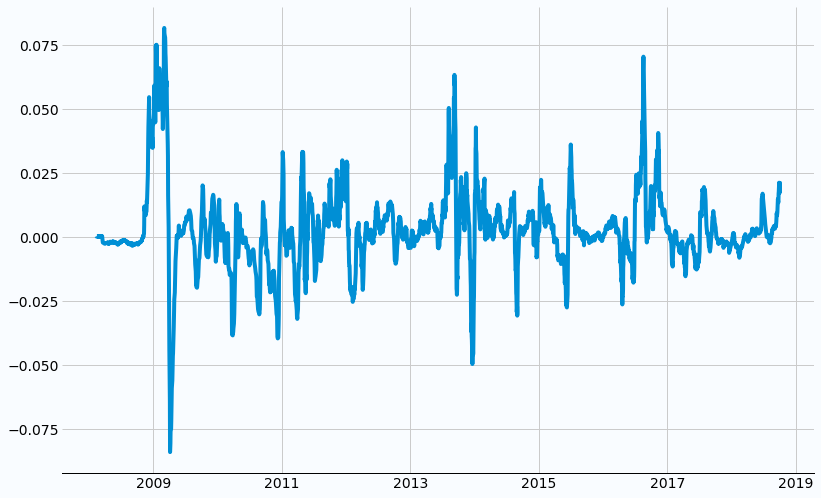

In [48]:
plt.plot(mnt['Date'],mnt['moving-avg-diff'])

In [49]:
def adf_test(y):
    # perform Augmented Dickey Fuller test
    print('Results of Augmented Dickey-Fuller test:')
    dftest = adfuller(y, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['test statistic', 'p-value', '# of lags', '# of observations'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value ({})'.format(key)] = value
    print(dfoutput)

In [51]:
adf_test(mnt['moving-avg-diff'])

Results of Augmented Dickey-Fuller test:
test statistic         -7.005819e+00
p-value                 7.126933e-10
# of lags               2.800000e+01
# of observations       3.513000e+03
Critical Value (1%)    -3.432213e+00
Critical Value (5%)    -2.862363e+00
Critical Value (10%)   -2.567208e+00
dtype: float64


Text(0.5,1,'Autocorrelation plot')

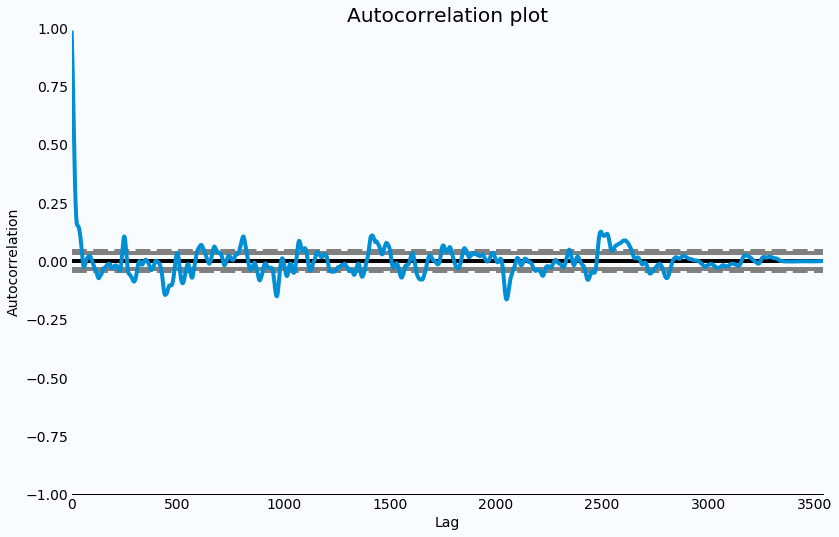

In [52]:
autocorrelation_plot(mnt['moving-avg-diff'])
plt.title('Autocorrelation plot')

Our differencing was successful and our time series is now stationary. With this we can now use an ARIMA model.

In [56]:
df = mnt[['Date','moving-avg-diff']]

In [59]:
df = df.set_index('Date')

Split into train and test data. We will use 2008 to 2017 as our training data. And 2018 as our test.

In [66]:
df.head()

,moving-avg-diff
Date,
2008-02-14,0.000395
2008-02-15,0.000245
2008-02-18,0.000213
2008-02-19,0.000243
2008-02-20,0.000287


In [62]:
df.tail()

,moving-avg-diff
Date,
2018-09-28,0.021280
2018-09-29,0.020236
2018-09-30,0.019186
2018-10-01,0.017344
2018-10-02,0.021749


In [67]:
train = df.loc['2008-01-01':'2017-12-31']
test = df.loc['2018-01-01':]

In [70]:
from pyramid.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

ModuleNotFoundError: No module named 'pyramid'

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


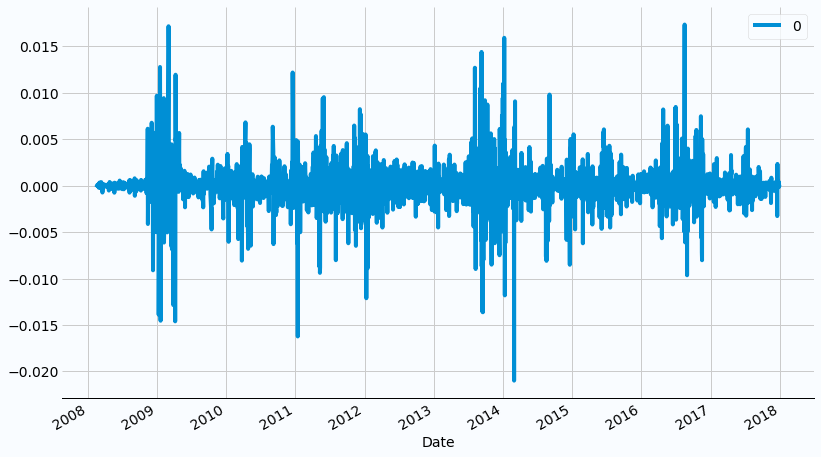

In [69]:
from pandas import DataFrame
residuals = DataFrame(model_fit.resid)
residuals.plot()

In [ ]:
model_fit.forecast()